In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [3]:
with open("Sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [4]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [5]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences) #makes sure it only ever sees the training set

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [6]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [8]:
#training
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
2/2 - 0s - loss: 0.6924 - accuracy: 0.5714 - 368ms/epoch - 184ms/step
Epoch 2/30
2/2 - 0s - loss: 0.6912 - accuracy: 0.5714 - 14ms/epoch - 7ms/step
Epoch 3/30
2/2 - 0s - loss: 0.6902 - accuracy: 0.5714 - 13ms/epoch - 7ms/step
Epoch 4/30
2/2 - 0s - loss: 0.6891 - accuracy: 0.5714 - 14ms/epoch - 7ms/step
Epoch 5/30
2/2 - 0s - loss: 0.6886 - accuracy: 0.5714 - 12ms/epoch - 6ms/step
Epoch 6/30
2/2 - 0s - loss: 0.6877 - accuracy: 0.5714 - 13ms/epoch - 6ms/step
Epoch 7/30
2/2 - 0s - loss: 0.6869 - accuracy: 0.5714 - 13ms/epoch - 6ms/step
Epoch 8/30
2/2 - 0s - loss: 0.6864 - accuracy: 0.5714 - 13ms/epoch - 7ms/step
Epoch 9/30
2/2 - 0s - loss: 0.6857 - accuracy: 0.5714 - 14ms/epoch - 7ms/step
Epoch 10/30
2/2 - 0s - loss: 0.6851 - accuracy: 0.5714 - 13ms/epoch - 6ms/step
Epoch 11/30
2/2 - 0s - loss: 0.6841 - accuracy: 0.5714 - 14ms/epoch - 7ms/step
Epoch 12/30
2/2 - 0s - loss: 0.6836 - accuracy: 0.5714 - 12ms/epoch - 6ms/step
Epoch 13/30
2/2 - 0s - loss: 0.6827 - accuracy: 0.5714 - 1

KeyError: 'val_accuracy'

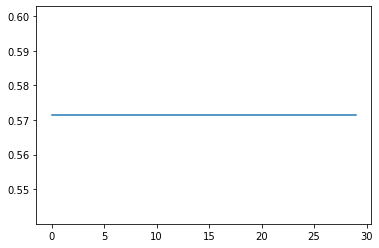

In [9]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [10]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

the tragic death of alejandro nieto and san francisco's gentrification ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
frantic john kerry looks on as teresa slowly lowered into kim jong-un's electric eel tank
1


In [11]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [12]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

KeyError: 392

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

Sentiment for new sentences:

In [13]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)

padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.43982404]
 [0.44157237]]
